## Notebook de Présentation de la PoC avec comparation de BERT et RoBERTa

**Nous avons voulu ici implémenter ces 2 modèles de NLP à des fins de comparaison dans le cadre d'une classification supervisée multiple :**

* Jeu de données : 1050 produits répartis équitablement en 7 catégories (150 pdts/ catégorie) ;
* Nettoyage rapide du texte : suppression des caractères spéciaux et espaces en trop - les tokénisations fournies par HuggingFace pour les 2 modèles utilisées prennent en charge les autres éléments ;
* Utilisation des modèles en se basant sur ce notebook d'exemple fourni par HuggingFace - "Fine Tuning Roberta for Sentiment Analysis" : https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb ;
* Evaluation et comparaison via différentes métriques adaptées à une problématique de classification ;
* Tentative d'utilisation de la librairie Captum pour l'analyse des features mais nous n'avons pas réussi à la configurer correctement.

In [1]:
# Import des packages :
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.special import softmax

# Visualisation :
import seaborn as sns
import matplotlib.pyplot as plt

# transformers :
import torch

from datetime import datetime
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from transformers import RobertaModel, RobertaTokenizer, BertTokenizer, BertModel


f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# On crée une première fonction qui applique un premier "nettoyage" du texte :

def first_cleaning_text(text):
    """On retire simplement certains éléments tels que les urls ou les chiffres ou caractères spéciaux"""
    # Supprimer les URLs
    text = re.sub(r'http\S+', '', text)
    # Supprimer les nombres
    text = re.sub(r'\b\d+(?:,\d+)?(?:\.\d+)?\b', '', text)
    # Supprimer les symboles non alphabétiques
    text = re.sub(r'[^\w\s]', '', text)
    # Supprimer les tokens entre parenthèses
    text = re.sub(r'\([^()]*\)', '', text)
    return text

In [3]:
# import du jeu de données :

pathfile = "flipkart_com-ecommerce_sample_1050.csv"

data = pd.read_csv(pathfile)

In [4]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
import json
# Je crée une nouvelle colonne ne comprenant que la catégorie "principale" des produits, à partir de la colonne product_category_tree :
data['product_category'] = data['product_category_tree'].apply(lambda x: json.loads(x)[0].split(">>")[0].strip())
data.head()

# J'en crée une autre qui concatène le nom de produit et la description :
data["name_desc_product"] = data["product_name"] + ". " + data["description"]
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category,name_desc_product
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Sathiyas Cotton Bath Towel. Specifications of ...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Eurospa Cotton Terry Face Towel Set. Key Featu...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Jaipur Print Cotton Floral King sized Double B...


In [6]:
# On crée un DataFrame plus réduit avec les variables qui nous intéressent :
df = data[['uniq_id', 'product_name', 'description', 'name_desc_product', 'product_category']]
df.head()

,uniq_id,product_name,description,name_desc_product,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas Cotton Bath Towel. Specifications of ...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa Cotton Terry Face Towel Set. Key Featu...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing


In [7]:
# Affichage répartition par catégorie :
df["product_category"].value_counts()

product_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [8]:
# Encodage des catégories
label_encoder = LabelEncoder()
df['categorie_encoded'] = label_encoder.fit_transform(df['product_category'])

C:\Users\Antoine\AppData\Local\Temp\ipykernel_20624\1566197324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categorie_encoded'] = label_encoder.fit_transform(df['product_category'])


In [9]:
df.head()

,uniq_id,product_name,description,name_desc_product,product_category,categorie_encoded
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas Cotton Bath Towel. Specifications of ...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa Cotton Terry Face Towel Set. Key Featu...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,4


In [10]:
df['name_desc_product_clean'] = df['name_desc_product'].apply(lambda x: first_cleaning_text(x))

C:\Users\Antoine\AppData\Local\Temp\ipykernel_20624\2654120346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name_desc_product_clean'] = df['name_desc_product'].apply(lambda x: first_cleaning_text(x))


In [11]:
new_df = df[['name_desc_product_clean', 'categorie_encoded']]

In [12]:
new_df.head()

,name_desc_product_clean,categorie_encoded
0,Elegance Polyester Multicolor Abstract Eyelet ...,4
1,Sathiyas Cotton Bath Towel Specifications of S...,0
2,Eurospa Cotton Terry Face Towel Set Key Featur...,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,4
4,Jaipur Print Cotton Floral King sized Double B...,4


### BERT

Comme indiqué plus haut, cette partie est largement inspirée par ce notebook : https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb

Nous avons essayé de l'adapté à notre problématique, à la fois en configurant le nombre de classes à prédire, et en obtenant plus de métriques (seule l'accuracy était renvoyée dans l'exemple).

In [13]:
bert_model_checkpoint = 'bert-base-uncased'

In [14]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained(bert_model_checkpoint, truncation=True, do_lower_case=True)

In [13]:
def calculate_metrics(preds, targets):
    return preds, targets

In [16]:
import torch
from torch.utils.data import Dataset

class ProductCategoryData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['name_desc_product_clean']
        self.targets = self.data['categorie_encoded']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }


In [17]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = ProductCategoryData(train_data, tokenizer, MAX_LEN)
testing_set = ProductCategoryData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (1050, 2)
TRAIN Dataset: (840, 2)
TEST Dataset: (210, 2)


In [19]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [20]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained(bert_model_checkpoint)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [21]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [22]:
model = BertClass()
model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [23]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [29]:
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [25]:
# Defining the training function on the 80% of the dataset for tuning the BERT model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [26]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            preds, targets = calculate_metrics(big_idx, targets)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            n_correct += (preds == targets).sum().item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return all_preds, all_targets, epoch_accu


In [27]:
# Définition d'une fonction pour évaluer le modèle sur le jeu de test :

def validate(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    tr_loss = 0
    nb_tr_steps = 0
    n_correct = 0
    
    with torch.no_grad():
        for _, data in tqdm(enumerate(data_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            preds, targets = calculate_metrics(big_idx, targets)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            n_correct += (preds == targets).sum().item()
            nb_tr_steps += 1
        
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / len(data_loader.dataset)
    return all_preds, all_targets, epoch_loss, epoch_accu



In [28]:
EPOCHS = 2
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train(epoch)
    
    # Validation sur le jeu de test
    test_preds, test_targets, test_acc = valid(model, testing_loader)
    print("Test Accuracy = %0.2f%%" % test_acc)
    test_precision = precision_score(test_targets, test_preds, average='weighted')
    test_recall = recall_score(test_targets, test_preds, average='weighted')
    test_f1 = f1_score(test_targets, test_preds, average='weighted')
    test_conf_matrix = confusion_matrix(test_targets, test_preds)
    
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test F1 Score: {test_f1}")
    print(f"Test Confusion Matrix:\n {test_conf_matrix}")
    print(f"Test Classification Report:\n {classification_report(test_targets, test_preds)}")

    print("-" * 50)

    # Validation sur le jeu d'entraînement
    train_preds, train_targets, train_loss, train_acc = validate(model, training_loader)
    print("Training Accuracy = %0.2f%%" % train_acc)
    train_precision = precision_score(train_targets, train_preds, average='weighted')
    train_recall = recall_score(train_targets, train_preds, average='weighted')
    train_f1 = f1_score(train_targets, train_preds, average='weighted')
    train_conf_matrix = confusion_matrix(train_targets, train_preds)
    
    print(f"Training Precision: {train_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Training Confusion Matrix:\n {train_conf_matrix}")
    print(f"Training Classification Report:\n {classification_report(train_targets, train_preds)}")

    print("-" * 50)


Epoch 1/2


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.9474859237670898
Training Accuracy per 5000 steps: 25.0


105it [21:16, 12.16s/it]


The Total Accuracy for Epoch 0: 52.61904761904762
Training Loss Epoch: 1.6141503668966748
Training Accuracy Epoch: 52.61904761904762


1it [00:02,  2.26s/it]

Validation Loss per 100 steps: 0.9403731822967529
Validation Accuracy per 100 steps: 100.0


53it [01:57,  2.23s/it]


Validation Loss Epoch: 1.050297200679779
Validation Accuracy Epoch: 86.66666666666667
Test Accuracy = 86.67%
Test Precision: 0.8706006053567028
Test Recall: 0.8666666666666667
Test F1 Score: 0.8647332805982594
Test Confusion Matrix:
 [[17  1  4  1  1  2  0]
 [ 3 21  2  0  2  0  0]
 [ 0  0 33  0  0  0  0]
 [ 1  0  1 23  2  1  0]
 [ 1  0  0  0 28  1  0]
 [ 2  0  1  2  0 35  0]
 [ 0  0  0  0  0  0 25]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.65      0.68        26
           1       0.95      0.75      0.84        28
           2       0.80      1.00      0.89        33
           3       0.88      0.82      0.85        28
           4       0.85      0.93      0.89        30
           5       0.90      0.88      0.89        40
           6       1.00      1.00      1.00        25

    accuracy                           0.87       210
   macro avg       0.87      0.86      0.86       210
weighted avg       0.87   

0it [00:00, ?it/s]f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
105it [07:28,  4.27s/it]


Training Accuracy = 85.95%
Training Precision: 0.8671229515858049
Training Recall: 0.8595238095238096
Training F1 Score: 0.8581738777886312
Training Confusion Matrix:
 [[ 93   2   2  10  12   5   0]
 [ 15  86  12   4   4   1   0]
 [  0   0 117   0   0   0   0]
 [  3   2  11 101   1   4   0]
 [  6   0   1   2 110   1   0]
 [  3   1  10   4   1  91   0]
 [  0   0   1   0   0   0 124]]
Training Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76       124
           1       0.95      0.70      0.81       122
           2       0.76      1.00      0.86       117
           3       0.83      0.83      0.83       122
           4       0.86      0.92      0.89       120
           5       0.89      0.83      0.86       110
           6       1.00      0.99      1.00       125

    accuracy                           0.86       840
   macro avg       0.87      0.86      0.86       840
weighted avg       0.87      0.86      

0it [00:00, ?it/s]f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.061950922012329
Training Accuracy per 5000 steps: 100.0


105it [21:23, 12.22s/it]


The Total Accuracy for Epoch 1: 88.33333333333333
Training Loss Epoch: 0.7448265837771552
Training Accuracy Epoch: 88.33333333333333


1it [00:02,  2.15s/it]

Validation Loss per 100 steps: 0.23129594326019287
Validation Accuracy per 100 steps: 100.0


53it [01:56,  2.20s/it]


Validation Loss Epoch: 0.3880192508112709
Validation Accuracy Epoch: 96.19047619047619
Test Accuracy = 96.19%
Test Precision: 0.9641660664916478
Test Recall: 0.9619047619047619
Test F1 Score: 0.9615288060784332
Test Confusion Matrix:
 [[22  0  0  1  1  2  0]
 [ 0 28  0  0  0  0  0]
 [ 0  0 33  0  0  0  0]
 [ 0  0  0 25  1  2  0]
 [ 0  0  0  0 30  0  0]
 [ 0  0  0  0  1 39  0]
 [ 0  0  0  0  0  0 25]]
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        26
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       0.96      0.89      0.93        28
           4       0.91      1.00      0.95        30
           5       0.91      0.97      0.94        40
           6       1.00      1.00      1.00        25

    accuracy                           0.96       210
   macro avg       0.97      0.96      0.96       210
weighted avg       0.96  

0it [00:00, ?it/s]f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
105it [07:25,  4.24s/it]

Training Accuracy = 95.12%
Training Precision: 0.9525582549502708
Training Recall: 0.9511904761904761
Training F1 Score: 0.9508763125102847
Training Confusion Matrix:
 [[106   0   0   4  12   2   0]
 [  5 110   2   3   2   0   0]
 [  0   0 117   0   0   0   0]
 [  2   0   0 115   0   5   0]
 [  1   0   0   1 118   0   0]
 [  0   0   0   2   0 108   0]
 [  0   0   0   0   0   0 125]]
Training Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89       124
           1       1.00      0.90      0.95       122
           2       0.98      1.00      0.99       117
           3       0.92      0.94      0.93       122
           4       0.89      0.98      0.94       120
           5       0.94      0.98      0.96       110
           6       1.00      1.00      1.00       125

    accuracy                           0.95       840
   macro avg       0.95      0.95      0.95       840
weighted avg       0.95      0.95      

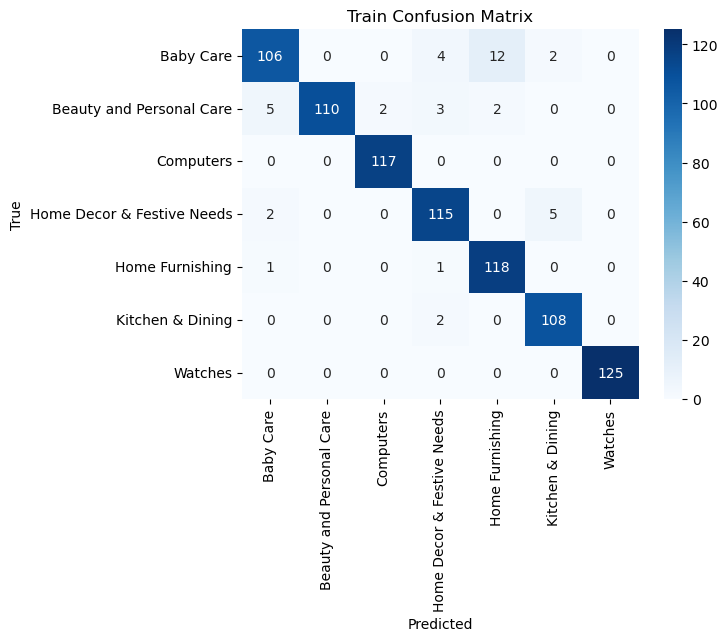

In [29]:
# Matrice de confusion train : 
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Train Confusion Matrix')
plt.show()

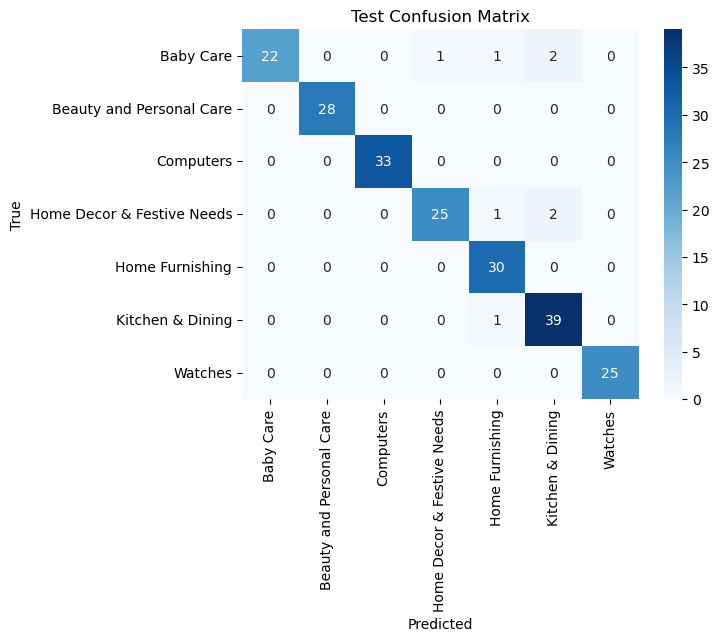

In [30]:
# Matrice de confusion train : 
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

### RoBERTa

Comme indiqué plus haut, cette partie est largement inspirée par ce notebook : https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb

Nous avons essayé de l'adapté à notre problématique, à la fois en configurant le nombre de classes à prédire, et en obtenant plus de métriques (seule l'accuracy était renvoyée dans l'exemple).

In [13]:
roberta_model_checkpoint = 'roberta-base'

In [14]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 3
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [15]:
import torch
from torch.utils.data import Dataset

class ProductCategoryData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['name_desc_product_clean']
        self.targets = self.data['categorie_encoded']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }


In [16]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = ProductCategoryData(train_data, tokenizer, MAX_LEN)
testing_set = ProductCategoryData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (1050, 2)
TRAIN Dataset: (840, 2)
TEST Dataset: (210, 2)


In [17]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [18]:
def calculate_metrics(preds, targets):
    return preds, targets

In [19]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained(roberta_model_checkpoint)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [20]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [21]:
model = RobertaClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [22]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [23]:
# Defining the training function on the 80% of the dataset for tuning the roberta model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [24]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            preds, targets = calculate_metrics(big_idx, targets)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            n_correct += (preds == targets).sum().item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return all_preds, all_targets, epoch_accu


In [25]:
# Définition d'une fonction pour évaluer le modèle sur le jeu de test :

def validate(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    tr_loss = 0
    nb_tr_steps = 0
    n_correct = 0
    
    with torch.no_grad():
        for _, data in tqdm(enumerate(data_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            preds, targets = calculate_metrics(big_idx, targets)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            n_correct += (preds == targets).sum().item()
            nb_tr_steps += 1
        
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / len(data_loader.dataset)
    return all_preds, all_targets, epoch_loss, epoch_accu



In [26]:
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [27]:
EPOCHS = 2
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train(epoch)
    
    # Validation sur le jeu de test
    test_preds, test_targets, test_acc = valid(model, testing_loader)
    print("Test Accuracy = %0.2f%%" % test_acc)
    test_precision = precision_score(test_targets, test_preds, average='weighted')
    test_recall = recall_score(test_targets, test_preds, average='weighted')
    test_f1 = f1_score(test_targets, test_preds, average='weighted')
    test_conf_matrix = confusion_matrix(test_targets, test_preds)
    
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test F1 Score: {test_f1}")
    print(f"Test Confusion Matrix:\n {test_conf_matrix}")
    print(f"Test Classification Report:\n {classification_report(test_targets, test_preds)}")

    # Validation sur le jeu d'entraînement
    train_preds, train_targets, train_loss, train_acc = validate(model, training_loader)
    print("Training Accuracy = %0.2f%%" % train_acc)
    train_precision = precision_score(train_targets, train_preds, average='weighted')
    train_recall = recall_score(train_targets, train_preds, average='weighted')
    train_f1 = f1_score(train_targets, train_preds, average='weighted')
    train_conf_matrix = confusion_matrix(train_targets, train_preds)
    
    print(f"Training Precision: {train_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Training Confusion Matrix:\n {train_conf_matrix}")
    print(f"Training Classification Report:\n {classification_report(train_targets, train_preds)}")

    print("-" * 50)


Epoch 1/2


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.973741888999939
Training Accuracy per 5000 steps: 0.0


280it [23:35,  5.05s/it]


The Total Accuracy for Epoch 0: 61.07142857142857
Training Loss Epoch: 1.2455079582652875
Training Accuracy Epoch: 61.07142857142857


1it [00:01,  1.54s/it]

Validation Loss per 100 steps: 0.23018018901348114
Validation Accuracy per 100 steps: 100.0


70it [01:50,  1.58s/it]


Validation Loss Epoch: 0.37458579667976927
Validation Accuracy Epoch: 90.47619047619048
Test Accuracy = 90.48%
Test Precision: 0.9200847327658921
Test Recall: 0.9047619047619048
Test F1 Score: 0.904011285125312
Test Confusion Matrix:
 [[17  0  0  1  4  4  0]
 [ 1 26  0  0  0  1  0]
 [ 0  0 32  0  0  1  0]
 [ 0  0  0 22  0  6  0]
 [ 0  0  0  0 28  2  0]
 [ 0  0  0  0  0 40  0]
 [ 0  0  0  0  0  0 25]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.65      0.77        26
           1       1.00      0.93      0.96        28
           2       1.00      0.97      0.98        33
           3       0.96      0.79      0.86        28
           4       0.88      0.93      0.90        30
           5       0.74      1.00      0.85        40
           6       1.00      1.00      1.00        25

    accuracy                           0.90       210
   macro avg       0.93      0.90      0.91       210
weighted avg       0.92  

0it [00:00, ?it/s]f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
280it [07:25,  1.59s/it]


Training Accuracy = 92.98%
Training Precision: 0.9381526907534841
Training Recall: 0.9297619047619048
Training F1 Score: 0.9291699446138788
Training Confusion Matrix:
 [[ 91   1   0   2  27   3   0]
 [  2 111   2   1   3   3   0]
 [  0   0 117   0   0   0   0]
 [  0   0   0 111   2   9   0]
 [  0   0   0   1 118   1   0]
 [  1   0   0   0   0 109   0]
 [  0   0   0   1   0   0 124]]
Training Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.83       124
           1       0.99      0.91      0.95       122
           2       0.98      1.00      0.99       117
           3       0.96      0.91      0.93       122
           4       0.79      0.98      0.87       120
           5       0.87      0.99      0.93       110
           6       1.00      0.99      1.00       125

    accuracy                           0.93       840
   macro avg       0.94      0.93      0.93       840
weighted avg       0.94      0.93      

0it [00:00, ?it/s]f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.25526323914527893
Training Accuracy per 5000 steps: 100.0


280it [22:09,  4.75s/it]


The Total Accuracy for Epoch 1: 93.21428571428571
Training Loss Epoch: 0.3067597545949476
Training Accuracy Epoch: 93.21428571428571


1it [00:01,  1.59s/it]

Validation Loss per 100 steps: 0.07513578236103058
Validation Accuracy per 100 steps: 100.0


70it [01:51,  1.59s/it]


Validation Loss Epoch: 0.20266274684774024
Validation Accuracy Epoch: 96.66666666666667
Test Accuracy = 96.67%
Test Precision: 0.9671621332191047
Test Recall: 0.9666666666666667
Test F1 Score: 0.9663079820122673
Test Confusion Matrix:
 [[22  1  0  1  0  2  0]
 [ 1 27  0  0  0  0  0]
 [ 0  0 33  0  0  0  0]
 [ 0  0  0 28  0  0  0]
 [ 0  0  0  0 30  0  0]
 [ 0  2  0  0  0 38  0]
 [ 0  0  0  0  0  0 25]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90        26
           1       0.90      0.96      0.93        28
           2       1.00      1.00      1.00        33
           3       0.97      1.00      0.98        28
           4       1.00      1.00      1.00        30
           5       0.95      0.95      0.95        40
           6       1.00      1.00      1.00        25

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97 

0it [00:00, ?it/s]f:\Utilisateur\Documents\Anaconda\Miniconda3\envs\new_nlp_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
280it [07:24,  1.59s/it]

Training Accuracy = 98.21%
Training Precision: 0.9825545221604661
Training Recall: 0.9821428571428571
Training F1 Score: 0.9820999515553585
Training Confusion Matrix:
 [[115   0   0   1   7   1   0]
 [  2 118   0   1   1   0   0]
 [  0   0 117   0   0   0   0]
 [  1   0   0 121   0   0   0]
 [  0   0   0   1 119   0   0]
 [  0   0   0   0   0 110   0]
 [  0   0   0   0   0   0 125]]
Training Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       124
           1       1.00      0.97      0.98       122
           2       1.00      1.00      1.00       117
           3       0.98      0.99      0.98       122
           4       0.94      0.99      0.96       120
           5       0.99      1.00      1.00       110
           6       1.00      1.00      1.00       125

    accuracy                           0.98       840
   macro avg       0.98      0.98      0.98       840
weighted avg       0.98      0.98      

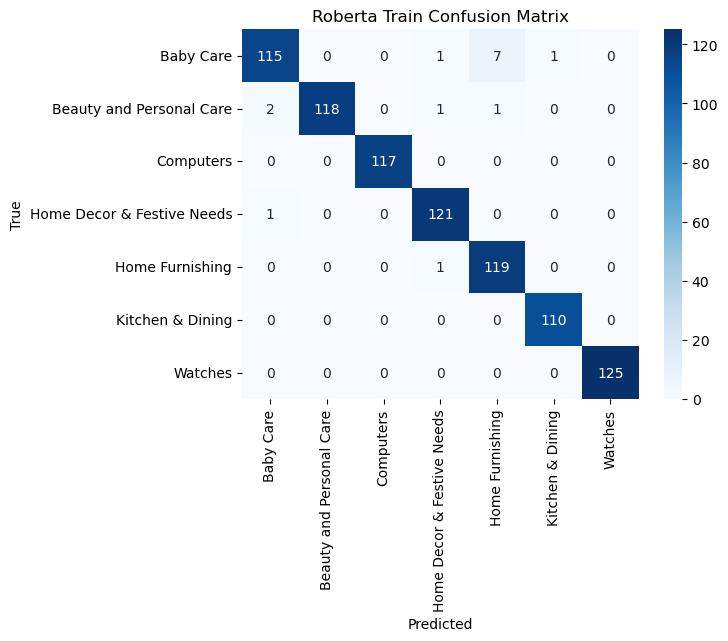

In [28]:
# Matrice de confusion train : 
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Roberta Train Confusion Matrix')
plt.show()

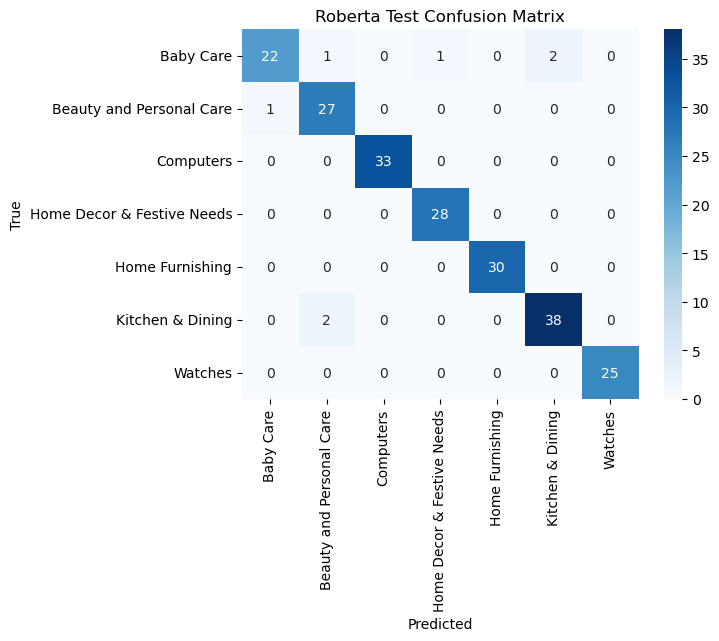

In [29]:
# Matrice de confusion train : 
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Roberta Test Confusion Matrix')
plt.show()

In [30]:
# Je crée un dataframe pour stocker les résultats des meilleurs epochs des modèles BERT et Roberta :
df_results = pd.DataFrame({"Model": ["BERT", "Roberta"],
                           "Train Accuracy": [0.9512, 0.9821],
                           "Train Precision": [0.9526, 0.9826],
                           "Train Recall": [0.9512, 0.9821],
                           "Train F1-Score": [0.9509, 0.9821],
                           "Eval Accuracy": [0.9619, 0.9667],
                           "Eval Precision": [0.9642, 0.9672],
                           "Eval Recall": [0.9619, 0.9667],
                           "Eval F1-Score": [0.9615, 0.9663]})
df_results


,Model,Train Accuracy,Train Precision,Train Recall,Train F1-Score,Eval Accuracy,Eval Precision,Eval Recall,Eval F1-Score
0,BERT,0.9512,0.9526,0.9512,0.9509,0.9619,0.9642,0.9619,0.9615
1,Roberta,0.9821,0.9826,0.9821,0.9821,0.9667,0.9672,0.9667,0.9663


In [31]:
# Enregistrement des résultats:
df_results.to_csv("new_results.csv", index=False)

In [32]:
metrics = ["Train Accuracy", "Train Precision", "Train Recall", "Train F1-Score", 
           "Eval Accuracy", "Eval Precision", "Eval Recall", "Eval F1-Score"]

eval_metrics = ["Eval Accuracy", "Eval Precision", "Eval Recall", "Eval F1-Score"]

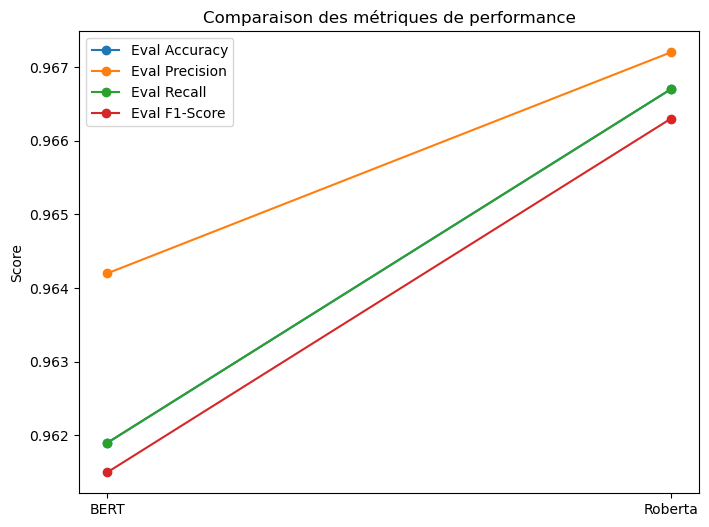

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
for metric in eval_metrics:
    ax.plot(df_results["Model"], df_results[metric], marker='o', label=metric)
ax.set_title('Comparaison des métriques de performance')
ax.set_ylabel('Score')
ax.legend(loc='best')
plt.show()

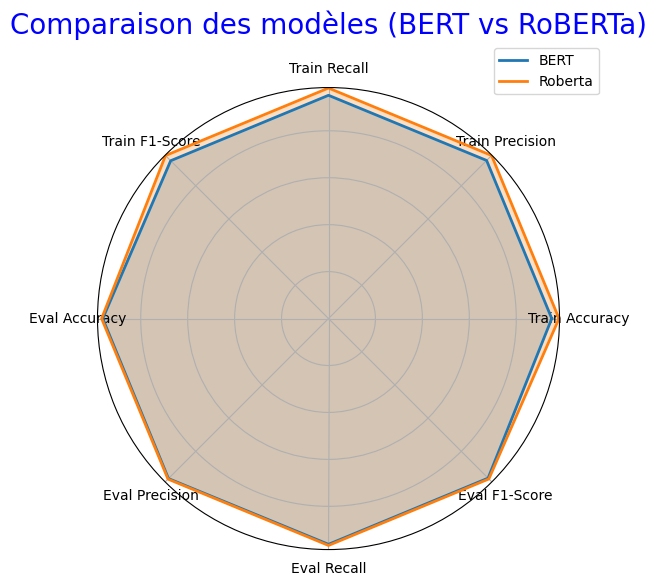

In [34]:
from math import pi

# Fonction pour créer un graphique radar
def make_radar_chart(data, labels, title):
    num_vars = len(labels)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for model in data['Model']:
        values = data[data['Model'] == model].iloc[0].drop(['Model']).values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.title(title, size=20, color='blue', y=1.1)
    plt.show()

labels = ["Train Accuracy", "Train Precision", "Train Recall", "Train F1-Score", 
          "Eval Accuracy", "Eval Precision", "Eval Recall", "Eval F1-Score"]
make_radar_chart(df_results, labels, 'Comparaison des modèles (BERT vs RoBERTa)')


### Tentative analyse de feature importance

Nous avons essayé de nous baser sur la présentation de la librairie Captum effectuée ici : https://captum.ai/tutorials/Bert_SQUAD_Interpret mais n'avons pas réussi à l'adapter à notre cas.

Après différentes tentatives, à la fois pour le modèle RoBERTa puis pour le modèle BERT, et sans succès, nous sommes au regret de ne pas pouvoir fournir une analyse de la feature importance de ce type de modèle et donc une interprétabilité approfondie de ceux-ci.

In [2]:
from captum.attr import IntegratedGradients, LayerIntegratedGradients

In [91]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [92]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [93]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [94]:
model = BertClass()
model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [95]:
# Je crée un échantillon de texte pour tester la fonction de préparation des données :
sample_text = new_df['name_desc_product_clean'].iloc[0]
sample_text

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral CurtainElegance Polyester Multicolor Abstract Eyelet Door Curtain  cm in Height Pack of  Price Rs  This curtain enhances the look of the interiorsThis curtain is made from  high quality polyester fabricIt features an eyelet style stitch with Metal RingIt makes the room environment romantic and lovingThis curtain is ant wrinkle and anti shrinkage and have elegant apparanceGive your home a bright and modernistic appeal with these designs The surreal attention is sure to steal hearts These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening you create the most special moments of joyous beauty given by the soothing prints Bring home the elegant curtain that softly filter

In [96]:
# on définit une fonction de préparation des données pour captum : 
def prepare_data(texts, tokenizer, max_len):
    inputs = tokenizer(
        texts, add_special_tokens=True, max_length=max_len, 
        padding='max_length', truncation=True, return_tensors="pt"
    )
    return inputs

In [97]:
sample_text[:100]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multic'

In [98]:
inputs = prepare_data([sample_text[:100]], tokenizer, 128)

In [99]:
# Vérif inputs sont des tenseurs PyTorch de type Long
input_ids = inputs['input_ids'].long().to(device)
attention_mask = inputs['attention_mask'].long().to(device)
token_type_ids = inputs['token_type_ids'].long().to(device)

In [108]:
attention_mask.type()

'torch.LongTensor'

In [109]:
# objet Integrated Gradients avec le modèle
ig = IntegratedGradients(model)

In [110]:
# Attributions des caractéristiques
attributions, delta = ig.attribute(
    inputs=(input_ids, attention_mask, token_type_ids), 
    target=0, return_convergence_delta=True, n_steps=50
)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [35]:
# On utilise la librairie Captum pour effectuer une analyse de sensibilité sur le modèle RoBERTa :
# On définit une fonction de prédiction : 
def predict(inputs):
    model.eval()
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'])
    return outputs


In [5]:
import torch
from transformers import BertTokenizer, BertModel
from captum.attr import IntegratedGradients

# On charge le tokenizer et le modèle
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # Convertir en LongTensor
        input_ids = input_ids.long()
        attention_mask = attention_mask.long()
        token_type_ids = token_type_ids.long()
        print(f"input_ids dtype in model: {input_ids.dtype}")
        print(f"attention_mask dtype in model: {attention_mask.dtype}")
        print(f"token_type_ids dtype in model: {token_type_ids.dtype}")
        
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = BertClass()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Préparation des données
def prepare_data(texts, tokenizer, max_len):
    inputs = tokenizer(
        texts, add_special_tokens=True, max_length=max_len, 
        padding='max_length', truncation=True, return_tensors="pt"
    )
    return inputs

sample_text = "Sample text for testing"
inputs = prepare_data([sample_text], tokenizer, 128)

# Conversion en tenseurs Long et déplacer sur GPU si disponible
input_ids = inputs['input_ids'].long().to(device)
attention_mask = inputs['attention_mask'].long().to(device)
token_type_ids = inputs['token_type_ids'].long().to(device)

# Vérif des types de tenseurs
print(f"input_ids dtype: {input_ids.dtype}, shape: {input_ids.shape}")
print(f"attention_mask dtype: {attention_mask.dtype}, shape: {attention_mask.shape}")
print(f"token_type_ids dtype: {token_type_ids.dtype}, shape: {token_type_ids.shape}")

# Fonction d'échelle personnalisée pour Captum
def custom_scale(inputs, baselines, alphas):
    scaled_inputs = []
    for input, baseline in zip(inputs, baselines):
        scaled_input = baseline + (input - baseline) * alphas[:, None]
        scaled_inputs.append(scaled_input.long())
    return scaled_inputs

# Integrated Gradients
ig = IntegratedGradients(model, multiply_by_inputs=False)

# attributions des caractéristiques
try:
    attributions, delta = ig.attribute(
        inputs=(input_ids, attention_mask, token_type_ids),
        # baselines=(input_ids * 0, attention_mask * 0, token_type_ids * 0),
        target=0, return_convergence_delta=True, n_steps=50)
    print("Attributions calculées avec succès")
except RuntimeError as e:
    print(f"RuntimeError: {e}")


input_ids dtype: torch.int64, shape: torch.Size([1, 128])
attention_mask dtype: torch.int64, shape: torch.Size([1, 128])
token_type_ids dtype: torch.int64, shape: torch.Size([1, 128])
input_ids dtype in model: torch.int64
attention_mask dtype in model: torch.int64
token_type_ids dtype in model: torch.int64
RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.
